In [1]:
path = '~/.ros/tracing/prbt-robot-trace-test9'

In [2]:
import os
import sys
import datetime as dt
from typing import List, Optional
from typing import Tuple
from typing import Union

import numpy as np
import pandas as pd

dir = '.' # os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0, os.path.join(dir, '../../tracetools_analysis/tracetools_analysis'))
sys.path.insert(0, os.path.join(dir, '../../ros2_tracing/tracetools_read'))
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [3]:
events = load_file(path)
handler = Ros2Handler.process(events)

converting trace directory: /home/vishnu/.ros/tracing/prbt-robot-trace-test9
converted 857075 events in 50.2 s
output written to: /home/vishnu/.ros/tracing/prbt-robot-trace-test9/converted
 [100%] [Ros2Handler]


In [4]:
data_util = Ros2DataModelUtil(handler.data)

callback_symbols = data_util.get_callback_symbols()

In [5]:
tpdo_data = data_util.data.canopen_tpdo_data
type(tpdo_data)

pandas.core.frame.DataFrame

In [6]:
tpdo_data

,timestamp,name,node_id,data
0,1684250027199471535,prbt_joint_1,3,89137
1,1684250027199534909,prbt_joint_2,4,-24262
2,1684250027199590569,prbt_joint_3,5,62460
3,1684250027199644856,prbt_joint_4,6,1977
4,1684250027199698643,prbt_joint_5,7,97601
...,...,...,...,...
36403,1684250081802963255,prbt_joint_2,4,-9075
36404,1684250081803027142,prbt_joint_3,5,86179
36405,1684250081803092348,prbt_joint_4,6,2031
36406,1684250081803154365,prbt_joint_5,7,89041


In [7]:
tpdo_data = tpdo_data.drop('node_id', axis=1)
tpdo_data['timestamp'] = pd.to_datetime(tpdo_data['timestamp'], unit='ns')
tpdo_data['time_increment'] = (tpdo_data['timestamp'] - tpdo_data['timestamp'].iloc[0]).dt.total_seconds()

In [8]:
divide_by_constant = lambda x: x/((180/np.pi)*1000)
tpdo_data['data'] = tpdo_data['data'].apply(divide_by_constant)

In [9]:
tpdo_prbt_joint_1 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_1')]
tpdo_prbt_joint_2 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_2')]
tpdo_prbt_joint_3 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_3')]
tpdo_prbt_joint_4 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_4')]
tpdo_prbt_joint_5 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_5')]
tpdo_prbt_joint_6 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_6')]

In [10]:
tpdo_prbt_joint_2

,timestamp,name,data,time_increment
1,2023-05-16 15:13:47.199534909,prbt_joint_2,-0.423452,0.000063
7,2023-05-16 15:13:47.209498821,prbt_joint_2,-0.423434,0.010027
13,2023-05-16 15:13:47.217607159,prbt_joint_2,-0.423434,0.018136
19,2023-05-16 15:13:47.226600737,prbt_joint_2,-0.423417,0.027129
25,2023-05-16 15:13:47.235557986,prbt_joint_2,-0.423417,0.036086
...,...,...,...,...
36379,2023-05-16 15:14:41.767061946,prbt_joint_2,-0.158389,54.567590
36385,2023-05-16 15:14:41.775661861,prbt_joint_2,-0.158389,54.576190
36391,2023-05-16 15:14:41.784849219,prbt_joint_2,-0.158389,54.585378
36397,2023-05-16 15:14:41.793832319,prbt_joint_2,-0.158389,54.594361


In [11]:
time_increments = np.array(tpdo_prbt_joint_2['time_increment']).astype(np.float64)
time_diff = np.diff(time_increments[1:])

# calculate the expected time increment
mean_time_diff = np.mean(time_diff)

print(f'mean time difference: {mean_time_diff}')

# check if any time differences are greater than the expected time increment
if any(time_diff > 14):
    print('Data skip detected!')
else:
    print('No data skip detected.')

num_skips = np.sum(time_diff > 15)

print(f'Total number of time skips for more the 15ms: {num_skips}')
print(f'Max time difference: {np.max(time_diff)}')
print(f'Min time difference: {np.min(time_diff)}')

mean time difference: 0.008999911710187932
No data skip detected.
Total number of time skips for more the 15ms: 0
Max time difference: 0.010396183000001002
Min time difference: 0.007443650999999107


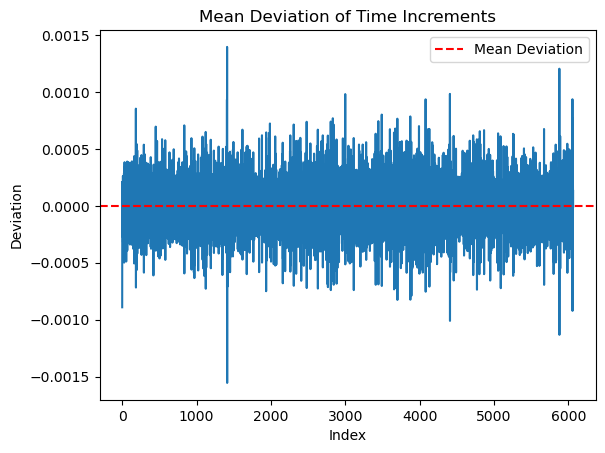

In [12]:
import matplotlib.pyplot as plt

# Assuming time_increments contains the time increments and mean_time_increment contains the mean value

deviations = time_diff - mean_time_diff
mean_deviation = np.mean(deviations)

plt.plot(deviations)
plt.axhline(mean_deviation, color='r', linestyle='--', label='Mean Deviation')
plt.xlabel('Index')
plt.ylabel('Deviation')
plt.title('Mean Deviation of Time Increments')
plt.legend()
plt.show()

# First test
- Controller update: 50 Hz
- Sync: 10ms
- Intepolationed time period: 15ms
---
- mean time difference: 0.010000101833557304
- No data skip detected.
- Total number of time skips for more the 15ms: 0
- Max time difference: 0.011175573999999244
- Min time difference: 0.008674769000002414

# Second test
- Controller update: 100 Hz
- Sync: 10ms
- Intepolationed time period: 15ms
---
- mean time difference: 0.010000072147980502
- No data skip detected.
- Total number of time skips for more the 15ms: 0
- Max time difference: 0.011042023999998207
- Min time difference: 0.009007880000005741

# Third test
- Controller update: 100 Hz
- Sync: 9ms
- Intepolationed time period: 15ms
---
- mean time difference: 0.008999911710187932
- No data skip detected.
- Total number of time skips for more the 15ms: 0
- Max time difference: 0.010396183000001002
- Min time difference: 0.007443650999999107